# Introduction and purpose of this file

The point of this is to remodify lookat_layers_270 with the new ASTE run sent from An:
- forward run: run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro
- year 2007 with the layers diagnostics: run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro

We will try to compare them here and see if we get the same thing

# Import the files and functions for run 1

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
forward_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_adxOFF_20022023_capxxN50_it0062_pk0000000007_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
imgpath = "/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/BarentsS_paper/figs/"
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS_Cwet/"
dirrun = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
dirState = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/STATE/"
dirgridw = "/scratch2/atnguyen/aste_270x450x180/GRID_wet/"

In [4]:
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0

# define the years of this that we want to read from
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
# times["2007"] = np.arange(1,13,1)
# times["2008"] = np.arange(1,3,1)
times["2007"] = np.arange(12,14,1)
times["2008"] = np.arange(1,2,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

tsteps = len(datetimes)-1
tsteps

1

In [5]:
names = np.array([
    '0000267408', '0000271440', '0000275904', '0000280224',
    '0000284688', '0000289008', '0000293472', '0000297936',
    '0000302256', '0000306720', '0000311040', '0000315504'
])
print(tsstr)
print(names[-2])

['0000311040' '0000315504']
0000311040


In [6]:
# set up the mask - we can try and use the Barents Sea mask here but not sure
data = np.load('masks_BS.npz')

# Access the saved masks
mask_south = data['mask_south']  # mask for heating and freshening (southern region)
mask_north = data['mask_north']  # mask for heating and salting (northern region)
mask_north_subsect = data['mask_north_subsect']  # mask for maximum location of change for heating and salting
mask_BS = data['mask_BS']

mask_south[mask_south == 0] = np.nan
mask_north[mask_north == 0] = np.nan
mask_north_subsect[mask_north_subsect == 0] = np.nan
mask_BS[mask_BS == 0] = np.nan

# set mymsk for the run below
mymsk = mask_BS
iB = 6
titlestr = "BarentsS"

### Do the budgeting and get the J terms

In [7]:
# we will use the bins from the An run so that we have the same thing in both sections
# Paths for the bins in this run
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1
# boundsT

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1
# boundsS

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

binmidTp = boundsT[1:-1]
binmidSp = boundsS[1:-1]

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)
nS,nT = 112,112

In [ ]:
# set a larger array for one year of the terms

vol_mesh_all = np.zeros((tsteps,nS,nT))
JtermsT_all = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all = np.zeros((tsteps,5,nS,nT))

In [ ]:
# reset the mean volume based on the terms
JtermsT = np.nanmean(JtermsT_all,axis=0)
JtermsS = np.nanmean(JtermsS_all,axis=0)
vol_mesh = np.nanmean(vol_mesh_all,axis=0)
JtermsS_nn = np.nanmean(JtermsS_nn_all,axis=0)
JtermsT_nn = np.nanmean(JtermsT_nn_all,axis=0)

In [ ]:
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms)

    vol_mesh_all[i] = vol_mesh
    JtermsT_all[i] = JtermsT
    JtermsS_all[i] = JtermsS
    JtermsT_nn_all[i] = JtermsT_nn
    JtermsS_nn_all[i] = JtermsS_nn

In [ ]:
tsstrhere

In [ ]:
# do the time-averaging -- setting this from January onward because this is what we have listed
# JtermsT = np.nanmean(JtermsT_all[1:],axis=0)
# JtermsS = np.nanmean(JtermsS_all[1:],axis=0)
# vol_mesh = np.nanmean(vol_mesh_all[1:],axis=0)

# JtermsS_nn = np.nanmean(JtermsS_nn_all[1:],axis=0)
# JtermsT_nn = np.nanmean(JtermsT_nn_all[1:],axis=0)

JtermsT = np.nanmean(JtermsT_all,axis=0)
JtermsS = np.nanmean(JtermsS_all,axis=0)
vol_mesh = np.nanmean(vol_mesh_all,axis=0)

JtermsS_nn = np.nanmean(JtermsS_nn_all,axis=0)
JtermsT_nn = np.nanmean(JtermsT_nn_all,axis=0)

### Create the T-S mesh for this (I think we should be able to use the same one in the layers)

In [ ]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [ ]:

# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

In [ ]:
# do a sample plot of the tendency terms here
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, 0.5, 3e0
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
timestr = datetimes[0].strftime("%Y-%m")
# timestr = datetimes[0].strftime("%Y")

# Plot limits
xlims, ylims = np.array([30, 35.5]), np.array([-2.3, 12])

# Titles for each subplot
titles = [
    "Observed Tendency", "ADV Tendency", "DF Tendency",
    "KPP Tendency", "Surface Tendency", "Sum of Tendencies"
]

# Figure setup
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 subplot layout
axes = axes.flatten()  # Flatten to iterate easily

for i, ax in enumerate(axes):
    if i < 5:
        U1, V1 = JtermsS[i], JtermsT[i]  # Select tendency terms
    else:
        # Sum up all terms for the last plot
        U1, V1 = sum(JtermsS[1:5]), sum(JtermsT[1:5])

    # Apply scaling and set zero values to NaN
    U1, V1 = U1 * alpha, V1 * beta
    U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

    # Background colormap
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01, zorder=2)

    # Quiver plot
    q = ax.quiver(Sbincent[::step, ::step], Tbincent[::step, ::step], 
                  U1[::step, ::step], V1[::step, ::step], 
                  width=0.005, scale=scale, zorder=3, headwidth=5)

    # Colorbar
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    # Titles, limits, and labels
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Quiver key (for scale reference)
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

    # Label each subplot (A, B, C, etc.)
    ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Save figure
plt.tight_layout()
# plt.savefig(imgpath + titlestr + "BarentsS" + timestr + ".png", dpi=300)
plt.savefig(imgpath + "samplebinning_nolayers" + timestr + ".png",dpi=300)
plt.show()

In [ ]:
del JtermsT,JtermsT_all,JtermsS,JtermsS_all,vol_mesh,vol_mesh_all,JtermsS_nn,JtermsS_nn_all,JtermsT_nn,JtermsT_nn_all

# Import the files for run 2, the one with layers

In [ ]:
# ts2dte(int(names[0]))

In [ ]:
# check that we are reading the same timesteps

In [ ]:
# we will be using the same tsstr values, check these are the ones listed
tsstr

In [ ]:
tsstr = np.sort(tsstr)
names = np.sort(names)

In [ ]:
for i,j in zip(tsstr,names):
    print(i,j)

In [ ]:
for fname in names:
    print(ts2dte(int(fname)))

In [ ]:
for fname in tsstr:
    print(ts2dte(int(fname)))

In [ ]:
# we need to drop the first month of this from the previous calculation
print(ts2dte(int(tsstr[0])))
print(tsstr[0])

In [ ]:
print(ts2dte(int(names[-2])))
print(names[-2])

### see if we can load for one month from the layers

Key from available_diagnostics.log for Ttend:

- LaTs2TH (m/s): Layer thickness tendency due to THETA surf. forc.
- LaTh2TH (m/s): Layer thickness tendency due to THETA horiz. diff.
- LaTz2TH (m/s): Layer thickness tendency due to THETA vert. diff.
- TzKp2TH (m/s): Layer thickness tendency due to THETA vert. diff. (KPP part)
- TzRe2TH (m/s): Layer thickness tendency due to THETA vert. diff. (Redi part)
- TzBg2TH (m/s): Layer thickness tendency due to THETA vert. diff. (Bolus part)?
- TKpg2TH: ?
- LTha2TH (m/s): Layer thickness tendency due to THETA horiz. adv.
- LTza2TH (m/s): Layer thickness tendency due to THETA vert. adv.
- LTBh2TH (m/s): Layer thickness tendency due    to THETA horiz. adv. (bolus part)
- LTBz2TH (m/s): Layer thickness tendency due to THETA vert. adv. (bolus)?
- LTto2TH (m/day): Layer thickness tendency due to all THETA terms.
- LaTs1SLT (m/s): Layer thickness tendency due to THETA surf. forc.
- LaTh1SLT (m/s): Layer thickness tendency due to THETA horiz. diff.
- LaTz1SLT (m/s): Layer thickness tendency due to THETA vert. diff.
- TzKp1SLT (m/s): Layer thickness tendency due to THETA vert. diff. (KPP part)
- TzRe1SLT (m/s): Layer thickness tendency due to THETA vert. diff. (Redi part)
- TzBg1SLT (m/s): bolus?
- TKpg1SLT: ?
- LTha1SLT (m/s): Layer thickness tendency due to THETA horiz. adv.
- LTza1SLT (m/s): Layer thickness tendency due to THETA vert. adv.
- LTBh1SLT (m/s): Layer thickness tendency due    to THETA horiz. adv. (bolus part)
- LTBz1SLT (m/s): Layer thickness tendency due to THETA vert. adv. (bolus)
- LTto1SLT (m/day): Layer thickness tendency due to all THETA terms.


Key from available_diagnostics.log for Stend:

- LaSs2TH (m/s): Layer thickness tendency due to SALT surf. forc.
- LaSh2TH (m/s): Layer thickness tendency due to SALT horiz. diff.
- LaSz2TH (m/s): Layer thickness tendency due to SALT vert. diff.
- SzKp2TH (m/s): Layer thickness tendency due to SALT vert. diff. (KPP part)
- SzRe2TH (m/s): Layer thickness tendency due to SALT vert. diff. (Redi part)
- SzBg2TH (m/s): Layer thickness tendency due to SALT vert. diff. (Bolus part)?
- SKpg2TH: ?
- LSha2TH (m/s): Layer thickness tendency due to SALT horiz. adv.
- LSza2TH (m/s): Layer thickness tendency due to SALT vert. adv.
- LSBh2TH (m/s): Layer thickness tendency due to SALT horiz. adv. (bolus part)
- LSBz2TH (m/s): Layer thickness tendency due to SALT vert. adv. (bolus part)
- LSto2TH (m/day): Layer thickness tendency due to all SALT terms.
- LaSs1SLT (m/s): Layer thickness tendency due to SALT surf. forc.
- LaSh1SLT (m/s): Layer thickness tendency due to SALT horiz. diff.
- LaSz1SLT (m/s): Layer thickness tendency due to SALT vert. diff.
- SzKp1SLT (m/s): Layer thickness tendency due to SALT vert. diff. (KPP part)
- SzRe1SLT (m/s): Layer thickness tendency due to SALT vert. diff. (Redi part)
- SzBg1SLT (m/s): Layer thickness tendency due to SALT vert. diff. (Bolus part)?
- SKpg1SLT: ?
- LSha1SLT (m/s): Layer thickness tendency due to SALT horiz. adv.
- LSza1SLT (m/s): Layer thickness tendency due to SALT vert. adv.
- LSBh1SLT (m/s): Layer thickness tendency due to SALT horiz. adv. (bolus part)
- LSBz1SLT (m/s): Layer thickness tendency due to SALT vert. adv. (bolus part)
- LSto1SLT (m/day): Layer thickness tendency due to all SALT terms.

In [ ]:
dirdiags = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/"

In [ ]:
# ffac=1e-6
# G_T=np.array([])
# metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend.0000723024.meta")
# metaS=parsemeta(dirdiags + "LAYERS/layers_3d_Stend.0000723024.meta")
# nFldsS = metaS["fldList"]
# nFldsT = metaT["fldList"]

In [ ]:
# try to just plot the total tendency from the Ttend files
ffac = 1e-6
dirInLayers = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/"
dirInBudg = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/BUDG/"

file_name = "layers_3d_Ttend"

meta_layers_3d_Ttend = parsemeta(dirInLayers + file_name + "." + names[0] + ".meta")
fldlist = np.array(meta_layers_3d_Ttend["fldList"])
print(fldlist)
varnames = np.array(["LTto2TH","LTto1SLT"])
# recs = np.array([])
# for var in varnames:
#     irec = np.where(fldlist == var)
#     recs = np.append(recs, irec[0][0])
# ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
# ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
# DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
# DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

In [ ]:
# try to do a plot of the total tendency from the Stend files
# try to just plot the total tendency
ffac = 1e-6
dirInLayers = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/diags/LAYERS/"
file_name = "layers_3d_Stend"

meta_layers_3d_Ttend = parsemeta(dirInLayers + file_name + "." + names[0] + ".meta")
fldlist = np.array(meta_layers_3d_Ttend["fldList"])
print(fldlist)
varnames = np.array(["LTto2TH","LTto1SLT"])
# recs = np.array([])
# for var in varnames:
#     irec = np.where(fldlist == var)
#     recs = np.append(recs, irec[0][0])
# ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
# ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
# DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
# DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

## create the volume distribution for one month

In [ ]:
names
dirInBudg

In [ ]:
# assuming all files are structured the same

file_name = 'budg2d_snap_set1'
meta_budg2d_snap_set1 = parsemeta(dirInBudg + file_name + "." + names[-2]+ ".meta")
print("reading " + file_name + "." + names[-2]+ ".meta")

# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))

# read the first timestep as an example
t1 = names[0]
read = [int(t1)]

# make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
ETAN,its,meta = rdmds(os.path.join(dirInBudg, file_name),read,returnmeta=True,rec=recs[0])

# choose by basin
ETAN = np.reshape(ETAN,(ny,nx))

# 3D, with rStar:
tmpvol = np.zeros((nz, ny, nx))
if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
    tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
    if myparms['useRFWF'] == 0:
        tmpvol[0, :, :] = np.zeros((ny, nx))
else:    # 4/22 look at this one
    if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
        tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
        tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
    else:
        tmp2 = drf3d / mk3D_mod(DD, tmp1)

    # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
    tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC)     # volume, m * m^2  = m^3
    tmpvol1 = (tmp1 * mk3D_mod(RAC, hfC))

tmpvol = tmpvol * np.tile(mymsk, (nz, 1, 1))
tmpvol1 = tmpvol1 * np.tile(mymsk, (nz, 1, 1))

In [ ]:
# print(np.nansum(tmpvol),np.nansum(tmpvol1))

In [ ]:
# load the THETA to do the binning
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + names[-2] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
t2 = int(names[-2])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

In [ ]:
# bin the volume we masked
binned_theta = bin_array(THETA,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(SALT,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

In [ ]:
# create the volume mesh
maskArc = mskBasin * mymsk   # this is somewhat redundant and we are not actually using iB below

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
mesh = create_TS_mesh(np.array(names[0]).reshape(1),nS,nT,npoints,binned_salinity.reshape(1,nz,ny,nx), binned_theta.reshape(1,nz,ny,nx),tmpvol.reshape(1,nz,ny,nx),idxs,dT,dS)

# sum the volume from the points in dimension 2
vol_mesh = np.nansum(mesh[0],axis=2)

In [ ]:
# now plot a sample TS diagram of this without the tendency terms
xlims, ylims = np.array([30, 35.5]), np.array([-2.3, 12])

fig = plt.figure(figsize = (4,4))

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, zorder=2,vmin=0.01)
ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.set_title(f" {timestr} from State Binning, Layers run")

plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

plt.savefig(imgpath + "statebinning_layersrun" + timestr + ".png",dpi=300)

In [ ]:
# maybe check the volume of the sea manually with the grid to make sure we are on the same scale
mygrid['DRF']
mygrid['DXG']
mygrid['DYG']

testx = mygrid['DXG']*mymsk
testx = np.tile(testx[np.newaxis,:,:],(nz,1,1))
testy = mygrid['DYG']*mymsk
testy = np.tile(testy[np.newaxis,:,:],(nz,1,1))
testz = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx)) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
print(testx.shape,testy.shape,testz.shape)

In [ ]:
testvolhere = testx*testy*testz

In [ ]:
np.nansum(testvolhere)

In [ ]:
np.nansum(vol_mesh)

## Now try to do the volume the way we did in lookat_layers

# Now we can try to plot the above with some quivers, but this already looks different

In [ ]:
# tsstr = '0000723024'
names[-2]

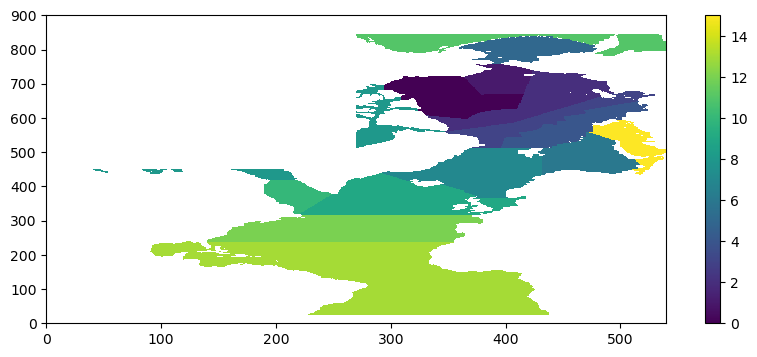

In [8]:
ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()
ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]

In [9]:
# create the basins based on the values and make subplots
#        1           2          3           4         5         6        7         8      9     10    11       12      13         14
#strb={'CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA','SPG','LabSea','NPac','NAtlantic','AtlS30'};
idxs = np.arange(0,14,1)
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

# REDEFINE THESE AND REPLACE STRI with similar phrasing for wet indices
iBarentsS2D = np.where(ind2d == 6)[0]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]

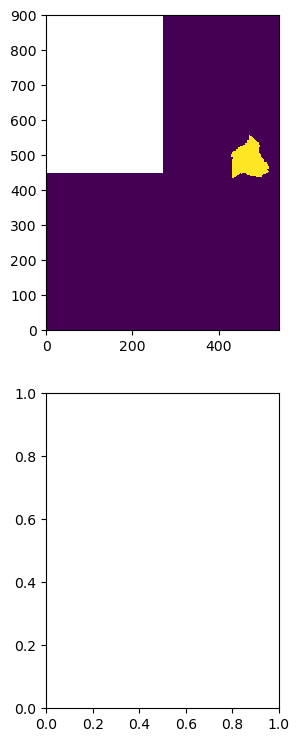

In [10]:
# # now we should be around line 179
# iBasinArctic = np.concatenate((iCanada2D,iChukchiS2D,iMakarovB2D,iAmundsenB2D,iNansenB2D))
# iBasinMedSPG = np.concatenate ((iBasinArctic, iBeringS2D, iBarentsS2D,iGINs2D,iCAA2D,iSPG2D,iLabSea2D))
# # iBasinGlobal = np.concatenate((iBasinMedSPG, iNPac2D,iNAtlantic2D,iAtlS302D))
# iBasinGlobal = iwetC2d[np.where(hf2d>0)[0]] ## QUESTION FOR AN - WHAT IS THE CORRECT WAY TO REFERENCE THIS

# make subplots based on these - hope we did this right
myzero = np.zeros((ny*nx))
fig,axs = plt.subplots(2,figsize = (3,9))

myzerotmp = myzero.copy() # copy for reference in loop
myzerotmp[iBarentsS2D] = 1
myzerotmp =  np.reshape(myzerotmp,(ny,nx))
myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
axs[0].pcolormesh(myzerotmp[0,:,:])

# myzerotmp = myzero.copy() # copy for reference in loop
# myzerotmp[iBasinMedSPG] = 1
# myzerotmp =  np.reshape(myzerotmp,(ny,nx))
# myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
# axs[1].pcolormesh(myzerotmp[0,:,:])

# myzerotmp = myzero.copy() # copy for reference in loop
# myzerotmp[iwetC2d[np.where(hf2d>0)[0]]] = 1
# myzerotmp =  np.reshape(myzerotmp,(ny,nx))
# myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
# axs[2].pcolormesh(myzerotmp[0,:,:])

In [11]:
# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
# TEST, ask An
# rac2d = rac2d.reshape((LwetC2d,2))
# rac2d = rac2d[:,0]
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape
hf2dtile = np.tile(hf2d,(nT-1,1))

RAC2d (146614,)
(4833023,)


In [12]:

# small.shape

ffac = 1e-6
names[-2]

'0000311040'

In [13]:
# try to read the volume from the layers
# now create vectors (366) - this is not correct I think
vol_distrib = {}
dT,dS = np.meshgrid(binwidthT,binwidthS)
i = 1

filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_p_" + str(LwetC2d) + "." + names[-2] + ".data"
tmp = read_float32_skip(filename, LwetC2d*(nS)*(nT),i-1)

tmp = np.reshape(tmp,(nT,nS,LwetC2d))              # LwetC2d x nS x nT
small = rac2d * hf2d
small = np.tile(small[np.newaxis,np.newaxis,:],(nT,nS,1))

tmp = tmp * small * ffac

# do just for BarentsS
tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)
tmp1[tmp1 == 0] = np.nan
vol_distrib["BarentsS"] = tmp1 / dT / dS  # [m^3 / (degC psu)]

del tmp1

(0.0, 40.0)

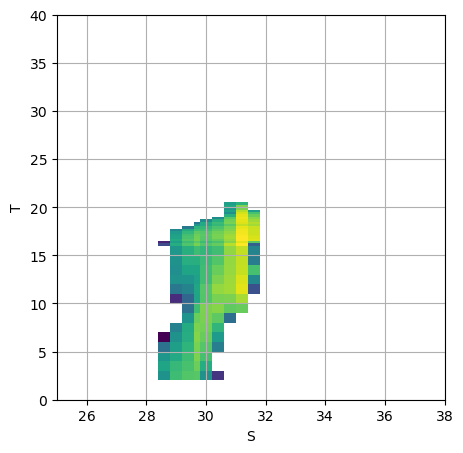

In [14]:
# try to plot with this volume distribution to see if different from the previous version

# # make a quick volume distribution of the entire region
plt.figure(figsize = (5,5))
plt.pcolormesh(Tbin,Sbin,np.log10(vol_distrib['BarentsS']))
plt.xlabel("S")
plt.ylabel("T")
plt.grid()
plt.xlim(25,38)
plt.ylim(0,40)

In [15]:
imymsk = np.where(mymsk == 1)

In [ ]:
# make subplots based on these - hope we did this right
myzero = np.full((ny*nx),np.nan)
fig,axs = plt.subplots(2,figsize = (3,9))

myzerotmp = myzero.copy() # copy for reference in loop
myzerotmp[iBarentsS2D] = 1
myzerotmp =  np.reshape(myzerotmp,(ny,nx))
myzerotmp = get_aste_tracer(myzerotmp,nfx,nfy)
axs[0].pcolormesh(myzerotmp[0,:,:])

myzerotmp = myzero.copy() # copy for reference in loop
# myzerotmp[imymsk] = 1
# myzerotmp =  np.reshape(myzerotmp,(ny,nx))
myzerotmp = get_aste_tracer(mymsk,nfx,nfy)
axs[1].pcolormesh(myzerotmp[0,:,:])

In [ ]:
# compare this to the one we did with the state

fig = plt.figure(figsize = (10,5))
# first subplot - from the state variables
ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, zorder=2,vmin=0.01)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_title(f" {timestr} from State Binning, Layers run")
plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# second subplot - from the layers run
ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_distrib['BarentsS']).T, cmap=cmap2, zorder=2,vmin=0.01)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_title(f" {timestr} from Layers run")
plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

plt.savefig(imgpath + "comparing_state_binning_to_layers" + timestr + ".png",dpi=300)

In [ ]:
print(np.nansum(np.log10(vol_mesh)))
print(np.nansum(np.log10(vol_distrib['BarentsS'])))

In [ ]:
# np.nansum(vol_mesh)

In [ ]:
# np.nansum(vol_distrib['BarentsS'])

## Do G_T and G_S and hopefully J terms

In [16]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(dirrun + "diags/LAYERS/layers_3d_Ttend." + str(names[-2])+ ".meta")
metaS=parsemeta(dirrun + "diags/LAYERS/layers_3d_Stend." + str(names[-2])+ ".meta")
nFldsS = metaS["fldList"]
nFldsT = metaT["fldList"]

In [ ]:
# metaT['fldList']  # 0, 1, 2, 7, 
metaS['fldList']   # 13, 14, 15, 16, 19, 22
a = metaS['fldList']
print(a[11],a[12],a[13],a[16],a[19],a[22])  # these are the ifldS values
# these are the total tend due to salt terms, tend due to salt surf forcing, tend due to salt horizontal diff, tend due to salt vertical diff
# ... tend due to salt horiz adv, tend due to salt vertical adv
ifldS = np.array([11,12,13,16,19,22])  # total tend, surf, hDiff, vDiff, hADV, vADV

In [ ]:
# from before ([0,1,2,3,4,7])

In [ ]:
metaT['fldList']   # 13, 14, 15, 16, 19, 22
a = metaT['fldList']
print(a[0],a[1],a[2],a[7],a[8],a[11])
ifldT = np.array([0,1,2,7,8,11])    # surf, hDiff, vDiff, hADV, vADV, total tend

In [ ]:
dirdiags

In [ ]:
tsstr

In [ ]:
setTtend=nFldsT.copy()
setStend=nFldsS.copy()

# define the G_T and G_S terms

In [ ]:
# make the G_T term
G_T = {}
G_T["BarentsS"] = {}
    
# now loop through
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float32_skip(dirrun + "diags/LAYERS/layers_3d_Ttend." + names[-2] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldT.shape[0]-1:
        residT = tmp
    else:
        residT = residT-tmp

    # just do the Barents Sea for this one
    a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
    G_T["BarentsS"][setTtend[ifldT[i]]] = a

G_T["BarentsS"]["residT"] = np.nansum(residT[:,iwet_BarentsS2D],axis=1)

In [ ]:
# create G_S for all basins (line 258)
G_S = {}
for ib in range(len(strb)):
    G_S[strb[ib]] = {}

# now loop through similar to ifldS
for i in range(len(ifldS)-1, -1, -1):
    tmp = read_float32_skip(dirrun + "diags/LAYERS/layers_3d_Stend." + names[-2] + ".data", nx*ny*(nT-1),ifldS[i])
    tmp = np.reshape(tmp,(nS-1,nx*ny))
    tmp = tmp[:,iwetC2d] * (rac2dtile * hf2dtile) * ffac
    if i == ifldS.shape[0]-1:
        residS = tmp
    else:
        residS = residS-tmp

    # just do for the Barents Sea
    a = np.nansum(tmp[:,iwet_BarentsS2D],axis=1)
    G_S["BarentsS"][setStend[ifldS[i]]] = a

# loop through again to calculate resid
G_S["BarentsS"]["residS"] = np.nansum(residS[:,iwet_BarentsS2D],axis=1)

In [ ]:
dirrun

In [ ]:
print(ts2dte(int('0000315504')))
print(ts2dte(int(names[-2])))
# tsstr[-3]

## We now did G_S and G_T and these are budgeted. Can move on to calculation of J (scary)

In [17]:
# read the fieldlists from the setTS_Stend_set1 and 2
# metaT=parsemeta(dirdiags + "LAYERS/layers_3d_Ttend.0000723024.meta")

# set 1 - the total terms we want for the budget
setTS_Ttend=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Ttend_set2=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set2_146614.0000315504.meta")["fldList"]

# set 1 - the total terms for the salt budget
setTS_Stend=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_146614.0000315504.meta")["fldList"]

# set 2 - the other terms
setTS_Stend_set2=parsemeta(dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set2_146614.0000315504.meta")["fldList"]

In [ ]:
print(setTS_Ttend)
print(setTS_Ttend_set2)
print()
print(setTS_Stend)
print(setTS_Stend_set2)

In [ ]:
# LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS LTBh_TS

In [ ]:
# setTSp = ['LaHc_TS']


# from previous lookat layers:
# setTS_Ttend = ['LaTs_TS', 'LaTh_TS', 'LaTz_TS', 'TzKp_TS', 'TzRe_TS', 'LTha_TS', 'LTza_TS', 'LTBh_TS', 'LTBz_TS', 'LTto_TS']
# setTS_Stend = ['LaSs_TS', 'LaSh_TS', 'LaSz_TS', 'SzKp_TS', 'SzRe_TS', 'LSha_TS', 'LSza_TS', 'LSBh_TS', 'LSBz_TS', 'LSto_TS']

# see if these are in the same order because stuff is hard-coded below
# layers_3d_TSjoint_Stend_146614.meta

In [ ]:
# THESE ARE THE TERMS IN THE BUDGET
# LaSs_TS LaSh_TS LaSz_TS LSha_TS LSza_TS LSBh_TS

In [ ]:
names[-1]

# print(setTS_Ttend_set1[1],setTS_Ttend_set1[4],setTS_Ttend_set1[8],setTS_Ttend_set1[9])
print(nFldsT)

In [18]:
import h5py
from scipy.io import loadmat
from scipy.io import savemat

In [19]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
# JUST FOR SET1 HERE - NOT FOR SET 2
# 287 - should be indexing nt, ns, wetpoints
# T, S, wetpoints
Jy = {}
# set each basin to its own dictionary
Jy["BarentsS"] = {}
Jy["BarentsS"]['G_T'] = {}
Jy["BarentsS"]['G_T']['residT'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Ttend)-1, -1, -1):
    t0 = time.localtime()
    # CHECK THIS IS SHAPED CORRECTLY - HOW
    filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Ttend_set1_" + str(LwetC2d) + "." + names[-2] + ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    # if at end of loop
    if i == len(setTS_Ttend)-1:
        f = (np.nansum(tmp, axis=2))
        f = np.nansum(f * binwidthS1)

    # double check the names in the listed file
    if i == len(setTS_Ttend)-1:
        # do not remove from the residual - this is the total tendency
        residT = tmp
    elif i==0 or i == 1 or i == 2 or i == 3 or i == 4:
        # LaTs_TS LaTh_TS LaTz_TS LTha_TS LTza_TS (LTBh_TS)
        # surface forcing, hDiff, vDiff, hADV, vADV, hADV bolus
        residT = residT - tmp

    #for ib in range(len(strb)):
    # use stri_wet, strb is names of basins
    #print(tmp.shape)
    tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)   # SUM OVER WET POINTS - should be of shape nS-1, nT-1
    # TEST:
    tmp1 = tmp1.T
    tmp2 = np.nansum(tmp1 * binwidthS1,axis=1)              # SUM OVER S - should be of shape nT-1
    Jy["BarentsS"][setTS_Ttend[i]] = tmp1
    Jy["BarentsS"]['G_T'][setTS_Ttend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2


myresid = np.nansum(residT[:,:,iwet_BarentsS2D],axis=2)    # SUM OVER WET POINTS - should be of shape nS-1, nT-1
# TEST:
myresid = myresid.T
Jy["BarentsS"]["residT"] = myresid
Jy["BarentsS"]["G_T"]["residT"] = np.nansum(Jy["BarentsS"]["residT"] * binwidthS1,axis=1)   #SUM OVER S - should be of shape nT-1

# set units and labels
Jy["unit"] = "m/s/psu"
Jy["G_T"] = {}
Jy["G_T"]["unit"] = "m/s"
Jy["G_T"]["descr"] = "G_T=integral(Jy,dS)"


# # write to file
matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
matname += "Jy_TSjoint_BarentsS.mat"
savemat(matname,Jy,do_compression=True)

(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)
(111, 111, 146614)


In [ ]:
# read from file - swap TS_tend names to read easier
namesTS = np.flip(setTS_Ttend)
namesTS = np.append("residT",namesTS)

matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
matname += "Jy_TSjoint_BarentsS.mat"

Jy_test = loadmat(matname)
Jy_read = {}
Jy_read["BarentsS"] = {}
Jy_read["BarentsS"]['G_T'] = {}
Jy_read["BarentsS"]['G_T']['residT'] = {}
nbasin = "BarentsS"

for ib in range(len(namesTS)):
    this_name = namesTS[ib]
    #print(np.sum(Jy_test[nbasin][0][0][0][0][0][ib] - Jy[nbasin]['G_T'][this_name]))    # manual check to see we're reading correct
    this_set = Jy_test["BarentsS"][0][0][0][0][0][ib].reshape(Jy_test["BarentsS"][0][0][0][0][0][ib].shape[1])
    Jy_read[nbasin]['G_T'][this_name] = this_set

    # we forgot to read in tmp1 from the function
    if ib>0:   # if not resid
        #print(np.sum(Jy_test[nbasin][0][0][ib] - Jy[nbasin][this_name]))
        this_set = Jy_test["BarentsS"][0][0][ib]
        Jy_read["BarentsS"][this_name] = this_set

# not sure how to get sum of residT but maybe we can skip this
#print(np.sum(Jy[nbasin]['residT'] - Jy_test[nbasin][0][0][-1]))    # manual check to see we're reading correct
Jy_read["BarentsS"]['residT'] = Jy_test["BarentsS"][0][0][-1]


Jy_read["unit"] = "m/s/psu"
Jy_read["G_T"] = {}
Jy_read["G_T"]["unit"] = "m/s"
Jy_read["G_T"]["descr"] = "G_T=integral(Jy,dS)"

In [20]:
del Jy,myresid

In [21]:
names[-2]

'0000311040'

In [ ]:
# DO NOT RUN IF HAS ALREADY BEEN CALCULATED
Jx = {}
# set each basin to its own dictionary
Jx["BarentsS"] = {}
Jx["BarentsS"]['G_S'] = {}
Jx["BarentsS"]['G_S']['residS'] = {}

rac = mygrid['RAC']
hf1 = hf1.reshape(ny,nx)

for i in range(len(setTS_Stend)-1, -1, -1):
    filename = dirrun + "diags/LAYERS_Cwet/layers_TSjoint_Stend_set1_" + str(LwetC2d) + "." + names[-2]+ ".data"
    tmp = read_float32_skip(filename, LwetC2d*(nS-1)*(nT-1),i)
    tmp = np.reshape(tmp,(nT-1,nS-1,LwetC2d))
    print(tmp.shape)

    small = rac2d * hf2d
    tmp = tmp * np.tile(small[np.newaxis,np.newaxis,:], (nT - 1, nS - 1,1)) * ffac

    if i == len(setTS_Stend)-1:
        # LSto_TS - total tendency
        residS = tmp
    elif i==0 or i == 1 or i == 2 or i == 3 or i == 4:
        # LaSs_TS LaSh_TS LaSz_TS LSha_TS LSza_TS LSBh_TS
        # surface, hdiff, vdiff, hADV, vADV, hADV bolus
        residS = residS - tmp

    # use stri_wet, strb is names of basins
    tmp1 = np.nansum(tmp[:,:,iwet_BarentsS2D],axis=2)   # should be of shape nS-1, nT-1
    # TEST
    tmp1 = tmp1.T
    thisbinwidthT1 = np.tile(binwidthT1[:,np.newaxis],(1, nS - 1))
    tmp2 = np.nansum(tmp1 * thisbinwidthT1, axis=1)                 # second dim is T because this is S tend
    Jx["BarentsS"][setTS_Stend[i]] = tmp1
    Jx["BarentsS"]['G_S'][setTS_Stend[i]] = tmp2
    del tmp
    del tmp1
    del tmp2

tmp1 = np.nansum(residS[:,:,iwet_BarentsS2D],axis=2)    # sum over geo space
mytileT1 = np.tile(binwidthT1[np.newaxis,:],(nS-1,1))  # nS-1 x nT-1
# TEST
mytileT1 = mytileT1.T
tmp2 = np.nansum(tmp1 * mytileT1, axis=0)     # sum over T ( dimension 0)
Jx["BarentsS"]["residS"] = tmp1    # should be of shape nS-1, nT-1
Jx["BarentsS"]["G_S"]["residS"] = tmp2 #should be of shape nT-1

# set units and labels
Jx["descr"] = "m/s/degC"
Jx["G_S"] = {}
Jx["G_S"]["descr"] = "[m/s], e.g., integral(LSto_TS,dT) = LSto1SLT"

# write to file
matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
matname += "Jx_TSjoint_BarentsS.mat"
savemat(matname,Jx,do_compression=True)

In [ ]:
# load from file the same as Jy, check to make sure these are the same
namesTS = np.flip(setTS_Stend)
namesTS = np.append("residS",namesTS)

matname = "/scratch2/mmurakami/aste_270x450x180/"
matname += "run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"
matname += "Jx_TSjoint.mat"

Jx_test = loadmat(matname)
Jx_read = {}
Jx_read["BarentsS"] = {}
Jx_read["BarentsS"]['G_S'] = {}
Jx_read["BarentsS"]['G_S']['residS'] = {}


for ib in range(len(namesTS)):
    this_name = namesTS[ib]
    #print(np.sum(Jx_test[nbasin][0][0][0][0][0][ib] - Jx[nbasin]['G_S'][this_name]))    # manual check to see we're reading correct
    this_set = Jx_test["BarentsS"][0][0][0][0][0][ib].reshape(Jx_test["BarentsS"][0][0][0][0][0][ib].shape[1])
    Jx_read["BarentsS"]['G_S'][this_name] = this_set

    if ib > 0:   # if not residS
        #print(np.sum(Jx_test[nbasin][0][0][ib] - Jx[nbasin][this_name]))
        this_set = Jx_test["BarentsS"][0][0][ib]
        Jx_read["BarentsS"][this_name] = this_set

#print(np.sum(Jx[nbasin]['residS'] - Jx_test[nbasin][0][0][-1]))    # manual check to see we're reading correct
Jx_read["BarentsS"]['residS'] = Jx_test["BarentsS"][0][0][-1]


Jx_read["unit"] = "m/s/psu"
Jx_read["G_S"] = {}
Jx_read["G_S"]["unit"] = "m/s"
Jx_read["G_S"]["descr"] = "G_T=integral(Jy,dS)"

In [ ]:
Jx = Jx_read.copy()
Jy = Jy_read.copy()
del Jx_read,Jy_read

# try plotting the G terms

In [ ]:
np.where(G_T['BarentsS']['LTto2TH'] > 0 )[0]
nT-1

ibegT = np.where(G_T["BarentsS"]['LTto2TH']>0)[0]
ibegT = max(0, min(ibegT) - 11)
ibegT

In [ ]:
# iendT = np.where(G_T['BarentsS']['LTto2TH'] > 0)[0]
# iendT = min(nT - 1, max(iendT) + 10)
iendT = nT-1
ibegT = 0
iendS = nS-1
ibegS = 0
iiS = np.arange(ibegS, iendS,1)
iiT = np.arange(ibegT, iendT, 1)

In [ ]:
print(binmidT.shape)
binmidT
print(G_T["BarentsS"]['LTto2TH'][iiT].shape)
print(binmidT[iiT].shape)

In [ ]:
# for i in range(len(strb[:1])):
jb = i
# print(jb)
# # create iendT and ibegT
# iendT = np.where(G_T["BarentsS"]['LTto2TH'] > 0)[0]
# iendT = min(nT - 1, max(iendT) + 10)
# ibegT = np.where(G_T["BarentsS"]['LTto2TH']>0)[0]
# ibegT = max(0, min(ibegT) - 11)
# iiT = np.arange(ibegT, iendT)

# # create iendS and ibegS
# iendS = np.where(G_S["BarentsS"]['LSto1SLT']>0)[0]
# if len(iendS) == 0:
#     iendS = np.array([500])
# iendS = min(nS-1, max(iendS) + 10)
# ibegS = np.where(G_S["BarentsS"]['LSto1SLT']>0)[0]
# if len(ibegS) == 0:
#     ibegS = np.array([-500])
# ibegS = max(1, min(ibegS) - 10)
# iiS = np.arange(ibegS, iendS,1)

print(iiS.shape,iiT.shape)

plt.figure(1)
plt.clf()
# Create a subplot with 2 rows, 2 columns, and select the first subplot
plt.subplot(121)
plt.plot(binmidT[iiT], G_T["BarentsS"]['LTto2TH'][iiT], 'b-',alpha=0.5,label="tot")
plt.plot(binmidT[iiT], G_T["BarentsS"]['LaTs2TH'][iiT], 'r-',alpha=0.5,label="surf")
plt.plot(binmidT[iiT], G_T["BarentsS"]['LaTh2TH'][iiT] + G_T["BarentsS"]['LaTz2TH'][iiT], 'g-',alpha=0.5,label="diff")
plt.plot(binmidT[iiT], G_T["BarentsS"]['LTha2TH'][iiT] + G_T["BarentsS"]['LTza2TH'][iiT], 'c-',alpha=0.5,label="adv")
plt.plot(binmidT[iiT], G_T["BarentsS"]['residT'][iiT], 'k-',alpha=0.5,label="resid")
plt.legend(loc="best")
plt.xlabel("pot T")
plt.ylabel('Resid G_T [Sv]')
plt.grid()
plt.subplot(222)
plt.plot(binmidT[iiT], G_T["BarentsS"]['residT'][iiT], 'k-', alpha=0.5,label="resid")
plt.xlabel("pot T")
#plt.ylabel("resid G_T")
plt.grid()

# plt.subplot(122)
# plt.plot(binmidT[iiS], G_S["BarentsS"]['LSto2TH'][iiS], 'b-',alpha=0.5,label="tot")
# plt.plot(binmidT[iiS], G_S["BarentsS"]['LaSs1SLT'][iiS], 'r-',alpha=0.5,label="surf")
# plt.plot(binmidT[iiS], G_S["BarentsS"]['LaSh1SLT'][iiS] + G_S["BarentsS"]['LaSz2SLT'][iiS], 'g-',alpha=0.5,label="diff")
# plt.plot(binmidT[iiS], G_S["BarentsS"]['LSha1SLT'][iiS] + G_S["BarentsS"]['LSza2SLT'][iiS], 'c-',alpha=0.5,label="adv")
# plt.plot(binmidT[iiS], G_S["BarentsS"]['residS'][iiS], 'k-',alpha=0.5,label="resid")
# plt.legend(loc="best")
# plt.xlabel("pot T")
# plt.ylabel('Resid G_S [Sv]')
# plt.grid()
# plt.subplot(222)
# plt.plot(binmidT[iiS], G_S["BarentsS"]['residT'][iiT], 'k-', alpha=0.5,label="resid")
# plt.xlabel("S")
# #plt.ylabel("resid G_T")
# plt.grid()

# plt.figure(2)
# plt.subplot(122)
# plt.plot(binmidT[iiT], Jy["BarentsS"]['G_T']['LTto_TS'][iiT], 'b-',alpha=0.5,label="tot")
# plt.plot(binmidT[iiT], Jy["BarentsS"]['G_T']['LaTs_TS'][iiT], 'r-',alpha=0.5,label="surf")
# plt.plot(binmidT[iiT], Jy["BarentsS"]['G_T']['LaTh_TS'][iiT] + Jy["BarentsS"]['G_T']['LaTz_TS'][iiT], 'g-',alpha=0.5,label="diff")
# plt.plot(binmidT[iiT], Jy["BarentsS"]['G_T']['LTha_TS'][iiT] + Jy["BarentsS"]['G_T']['LTza_TS'][iiT], 'c-',alpha=0.5,label="adv")
# plt.plot(binmidT[iiT], Jy["BarentsS"]['G_T']['residT'][iiT], 'k-',alpha=0.5,label="resid")
# plt.legend(loc="best")
# plt.xlabel("pot T")
# plt.ylabel('Resid G_T [Sv]')
# plt.grid()
# plt.subplot(222)
# plt.plot(binmidT[iiT],Jy["BarentsS"]['G_T']['residT'][iiT], 'k-',alpha=0.5,label="resid")
# plt.grid()

# plt.subplot(223)
# plt.plot(binmidS[iiS], Jx["BarentsS"]['G_S']['LSto_TS'][iiS], 'b-',alpha=0.5,label="tot")
# plt.plot(binmidS[iiS], Jx["BarentsS"]['G_S']['LaSs_TS'][iiS], 'r-',alpha=0.5,label="surf")
# plt.plot(binmidS[iiS], Jx["BarentsS"]['G_S']['LaSh_TS'][iiS] + Jx["BarentsS"]['G_S']['LaSz_TS'][iiS], 'g-',alpha=0.5,label="diff")
# plt.plot(binmidS[iiS], Jx["BarentsS"]['G_S']['LSha_TS'][iiS] + Jx["BarentsS"]['G_S']['LSza_TS'][iiS], 'c-',alpha=0.5,label="adv")
# plt.plot(binmidS[iiS], Jx["BarentsS"]['G_S']['residS'][iiS], 'k-',alpha=0.5,label="resid")
# plt.legend(loc="best")
# plt.xlabel("S")
# plt.ylabel('Resid G_S [Sv]')
# plt.grid()
# plt.subplot(224)
# plt.plot(binmidS[iiS], Jx["BarentsS"]['G_S']['residS'][iiS], 'k-',alpha=0.5)
# plt.grid()

# plt.figure(3)
# plt.subplot(2,5,1)
# plt.plot(binmidT[iiT], G_T["BarentsS"]['LTto2TH'][iiT] - Jy[strb[ib]]['G_T']['LTto_TS'][iiT], '-',alpha=0.5)
# plt.xlabel("T")
# plt.grid()
# plt.subplot(2,5,6)
# plt.plot(binmidS[iiS], G_S["BarentsS"]['LSto1SLT'][iiS] - Jx[strb[ib]]['G_S']['LSto_TS'][iiS], '-',alpha=0.5)
# plt.xlabel("S")
# plt.grid()
# plt.subplot(2,5,2)
# plt.plot(binmidT[iiT], G_T["BarentsS"]['LaTs2TH'][iiT] - Jy[strb[ib]]['G_T']['LaTs_TS'][iiT], '-',alpha=0.5)
# plt.xlabel("T")
# plt.grid()
# plt.subplot(2,5,7)
# plt.plot(binmidS[iiS], G_S["BarentsS"]['LaSs1SLT'][iiS] - Jx[strb[ib]]['G_S']['LaSs_TS'][iiS], '-',alpha=0.5)
# plt.xlabel("S")
# plt.grid()
# plt.subplot(2,5,3)
# plt.plot(binmidT[iiT], G_T["BarentsS"]['LaTh2TH'][iiT] + G_T["BarentsS"]['LaTz2TH'][iiT] - \
#          Jy[strb[ib]]['G_T']['LaTh_TS'][iiT] + Jy["BarentsS"]['G_T']['LaTz_TS'][iiT], '-',alpha=0.5)
# plt.xlabel("T")
# plt.grid()
# plt.subplot(2,5,8)
# plt.plot(binmidS[iiS],G_S["BarentsS"]['LaSh1SLT'][iiS] + G_S["BarentsS"]["LaSz1SLT"][iiS] - \
#          Jx["BarentsS"]['G_S']["LaSh_TS"][iiS] + Jx["BarentsS"]["G_S"]["LaSz_TS"][iiS],'-',alpha=0.5)
# plt.xlabel("S")
# plt.grid()
# plt.subplot(2,5,4)
# plt.plot(binmidT[iiT], G_T["BarentsS"]['LTha2TH'][iiT] + G_T["BarentsS"]['LTza2TH'][iiT] - \
#          Jy[strb[ib]]['G_T']['LTha_TS'][iiT] + Jy["BarentsS"]['G_T']['LTza_TS'][iiT], '-',alpha=0.5)
# plt.xlabel("T")
# plt.grid()
# plt.subplot(2,5,9)
# plt.plot(binmidS[iiS],G_S["BarentsS"]['LSha1SLT'][iiS] + G_S["BarentsS"]["LSza1SLT"][iiS] - \
#          Jx["BarentsS"]['G_S']["LSha_TS"][iiS] + Jx["BarentsS"]["G_S"]["LSza_TS"][iiS],'-',alpha=0.5)
# plt.xlabel("S")
# plt.grid()
# plt.subplot(2,5,5)
# plt.plot(binmidT[iiT], G_T["BarentsS"]['residT'][iiT] - Jy[strb[ib]]['G_T']['residT'][iiT],'-',alpha=0.5)
# plt.xlabel("T")
# plt.grid()
# plt.subplot(2,5,10)
# plt.plot(binmidS[iiS],G_S["BarentsS"]['residS'][iiS] - Jx["BarentsS"]['G_S']["residS"][iiS],'-',alpha=0.5)
# plt.xlabel("S")
# plt.grid()

In [ ]:
G_S["BarentsS"].keys()

In [ ]:
binmidT.shape

# try plotting J terms

In [ ]:
Tbin2,Sbin2 = np.meshgrid(binmidTp,binmidSp)

In [ ]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize = (6,5))

xlims, ylims = np.array([30, 35.5]), np.array([-2.3, 12])
plt.subplot(111)
i = 4
plt.pcolormesh(Sbin,Tbin,np.log10(vol_distrib["BarentsS"].T), cmap=cmap2, zorder=2,vmin=0.0001)
plt.grid()
plt.title("BarentsS Total Tend")
plt.xlabel('S')
plt.ylabel('T')
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar(label=r"$\frac{m^3}{deg C/kg}$")
Usel = Jx["BarentsS"]['LSto_TS']  #[iiS,:][:,iiT]
Vsel = Jy["BarentsS"]['LTto_TS']  #[iiS,:][:,iiT]
hh = plt.quiver(Sbin2, Tbin2, Usel, Vsel, scale=50,width=0.003,zorder=5)

In [ ]:
a =  Jx["BarentsS"]['LSto_TS']
plt.pcolormesh(a)

In [ ]:
a =  Jy["BarentsS"]['LTto_TS']
plt.pcolormesh(a)